### Large-scale meta evaluation on groundedness feedback function with [LLM-AggreFact](https://huggingface.co/datasets/lytang/LLM-AggreFact) 

In [ ]:
from trulens.benchmark.benchmark_frameworks.experiments.dataset_preprocessing import (
    generate_balanced_llm_aggrefact_benchmark,
)

llm_aggrefact_df = generate_balanced_llm_aggrefact_benchmark(split="test")

In [ ]:
llm_aggrefact_df

In [ ]:
for dataset_name in llm_aggrefact_df["dataset"].unique():
    print(dataset_name)
    print(
        llm_aggrefact_df[
            llm_aggrefact_df["dataset"] == dataset_name
        ].label.value_counts()
    )

## Below is the statistics of the datasets in LLM-AggreFact:
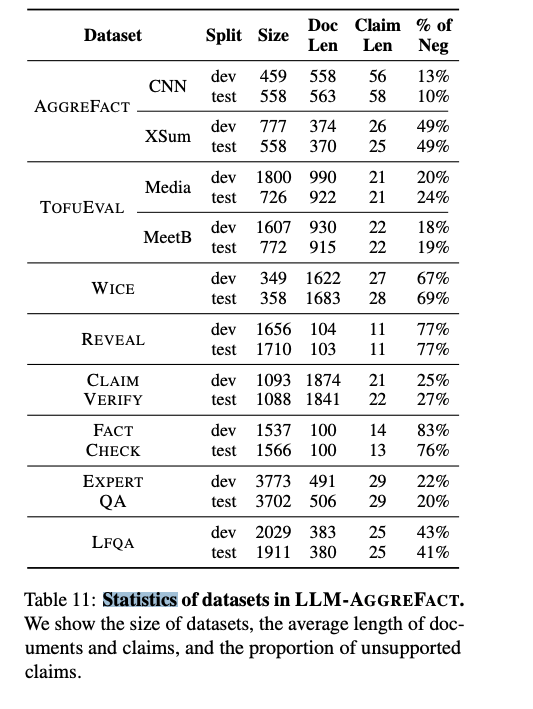

In [ ]:
from langchain.llms import Ollama
from trulens.core.session import TruSession
from trulens.providers.openai import OpenAI

session = TruSession()
session.reset_database()

gpt_4o = OpenAI(model_engine="gpt-4o")
bespoke_minicheck_7b_provider = Ollama(
    base_url="http://localhost:11434", model="bespoke-minicheck:7b"
)


def gpt_4_groundedness(doc: str, claim: str, gt_score: float):
    score, cot = gpt_4o.groundedness_measure_with_cot_reasons(
        source=doc,
        statement=claim,
        use_sent_tokenize=True,
        filter_trivial_statements=True,
    )
    return f"{score};{gt_score};{cot}"


def bespoke_minicheck_7b(doc: str, claim: str, gt_score: float):
    prompt = f"""
    Document: {doc}
    Claim: {claim}
    """
    response = bespoke_minicheck_7b_provider(prompt)
    score = 1.0 if response.lower() == "yes" else 0.0
    return f"{score};{gt_score};N/A"


EVAL_NAME_TO_FUNC = {
    "gpt-4o": gpt_4_groundedness,
    "bespoke-minicheck:7b": bespoke_minicheck_7b,
}

In [ ]:
from trulens.apps.basic import TruBasicApp
from trulens.core import Feedback
from trulens.core import Provider


class CustomTermFeedback(Provider):
    def feedback_score(self, output) -> float:
        return float(output.split(";")[0])

    def gt_score(self, output) -> float:
        return float(output.split(";")[1])


custom_term_feedback = CustomTermFeedback()

f_gt_score = Feedback(
    custom_term_feedback.gt_score,
    name="GT Score",
    higher_is_better=True,
).on_output()

f_feedback_score = Feedback(
    custom_term_feedback.feedback_score,
    name="Predicted/Feedback Score",
    higher_is_better=True,
).on_output()


CUSTOM_FEEDBACK_FUNCS = [
    f_gt_score,
    f_feedback_score,
]


def run_groundedness_experiment(
    func_wrapper, dataset_df, app_name, app_version="dataset_name"
):
    tru_wrapped_app = TruBasicApp(
        func_wrapper,
        app_name=app_name,
        app_version=f"{app_version}",
        feedbacks=CUSTOM_FEEDBACK_FUNCS,
    )

    for i, row in dataset_df.iterrows():
        doc = row["doc"]
        claim = row["claim"]
        gt_score = row["label"]

        try:
            with tru_wrapped_app as _:
                tru_wrapped_app.app(doc, claim, gt_score)

        except Exception as e:
            print(
                f"Error {e} in run_feedback_experiment row {i} with doc {doc} and claim {claim}"
            )

In [ ]:
for eval_name in EVAL_NAME_TO_FUNC.keys():
    eval_func = EVAL_NAME_TO_FUNC[eval_name]
    for dataset_name in llm_aggrefact_df["dataset"].unique():
        print(f"Running {eval_name} on {dataset_name}")
        sub_df = llm_aggrefact_df[llm_aggrefact_df["dataset"] == dataset_name]
        run_groundedness_experiment(
            func_wrapper=eval_func,
            dataset_df=sub_df,
            app_name=eval_name,
            app_version=dataset_name,
        )

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

csv_path = "../results/LLM AggreFact groundedness.csv"
df = pd.read_csv(csv_path)

# Aggregate metrics by app_name
aggregated = (
    df.groupby("APP_NAME")
    .agg(
        total_tp=("TOTAL_TP", "sum"),
        total_tn=("TOTAL_TN", "sum"),
        total_fp=("TOTAL_FP", "sum"),
        total_fn=("TOTAL_FN", "sum"),
    )
    .reset_index()
)


def plot_confusion_matrix(tp, tn, fp, fn, app_name):
    matrix = [[tp, fn], [fp, tn]]

    labels = ["Predicted Positive", "Predicted Negative"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.title(f"Confusion Matrix for {app_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


for _, row in aggregated.iterrows():
    tp = row["total_tp"]
    tn = row["total_tn"]
    fp = row["total_fp"]
    fn = row["total_fn"]
    app_name = row["APP_NAME"]

    # Plot the aggregated confusion matrix
    plot_confusion_matrix(tp, tn, fp, fn, app_name)